# Finding pairs and tiles of EMIT/S2

## Dependencies

### Installs

In [63]:
!pip install -q numpy xarray rasterio shapely pyproj matplotlib panel holoviews hvplot tqdm jupyter_bokeh pystac-client earthaccess netCDF4 spectral rioxarray hvplot
!pip install -q "git+https://github.com/EnSpec/hytools.git"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [64]:
!git clone https://github.com/martasumyk/hyperspectral_super-resolution

Cloning into 'hyperspectral_super-resolution'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 258 (delta 0), reused 1 (delta 0), pack-reused 254 (from 1)
Receiving objects: 100% (258/258), 4.84 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (143/143), done.


In [65]:
%cd /content/hyperspectral_super-resolution/

/content/hyperspectral_super-resolution


In [66]:
!pip install POT

In [67]:
!apt-get update
!apt-get install -y gdal-bin

!gdalwarp --version

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,917 B in 2s (2,475 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.8.4+dfsg

### Imports

In [68]:
import os, json, math
from pathlib import Path
from datetime import datetime, date, timezone, timedelta
from datetime import timezone
from pprint import pprint
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from rasterio.windows import Window, transform as win_transform



import numpy as np
import json
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
from tqdm import tqdm

import panel as pn
import holoviews as hv
import hvplot.xarray

from pystac_client import Client

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from EMIT_data.emit_tools import emit_xarray
from s2_data.s2_utils import plot_s2_truecolor

from s2_data.s2_utils import (
    point_buffer_bbox, get_item_dt_utc, download_asset, plot_s2_truecolor, find_best_s2_for_date
)
from s2_data.cloud_utils import (
    best_asset_key, reproject_geom, scl_metrics, count_cloud_pixels
)

from EMIT_data.EMIT_utils import (
    login, search, download_reflectance, open_reflectance, attach_wavelengths,
    choose_best_emit_per_date, _emit_cloud_pct
)
from EMIT_data.emit_tools import quality_mask, band_mask
from EMIT_data.emit_proj import nc_to_envi, convert_emit_nc_to_envi
from EMIT_data.viz import show_emit_rgb_from_envi

pn.extension("tabulator")
hv.extension("bokeh")
from datetime import date
from pathlib import Path

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform
from pyproj import CRS
from rasterio.windows import from_bounds, transform as win_transform

from s2_data.s2_utils import download_s2_truecolor, download_s2_spectral_stack

from s2_emit import (
    load_s2_srf_from_xlsx,
    load_emit_envi_rfl, load_emit_wavelengths_from_nc,
    pseudo_s2_srf_integral, pseudo_s2_rgb,
    load_s2_rgb_u8, resize_s2_rgb_to, show_side_by_side,
    apply_shared_percentile_stretch, histogram_match_rgb, ot_match_rgb_sinkhorn_pot,
)
from s2_emit.viz import print_raster_geometry
from s2_emit.synth import crop_to_overlap

## Earthdata login

Login to https://urs.earthdata.nasa.gov/.

In [69]:
login(persist=True)

## Global parameters & paths

In [70]:
# -------------------------
# ROI (point + buffer)
# -------------------------
LAT = 36.10
LON = -112.11
SEARCH_BUFFER_M = 20_000  # meters radius around point

# -------------------------
# Time window (UTC dates)
# -------------------------
DATE_START = date(2022, 1, 1)
DATE_END = date.today()

# -------------------------
# S2 search
# -------------------------
S2_API = "https://earth-search.aws.element84.com/v1"
S2_COLLECTION = "sentinel-2-l2a"

# -------------------------
# Quality filters
# -------------------------
MAX_S2_CLOUD_FRAC = 0.5
MAX_EMIT_CLOUD_PCT = 50.0  # currently used only for reporting/metadata unless you enforce it

# -------------------------
# Outputs
# -------------------------
ROOT = Path("pairs_output")
EMIT_DIR = ROOT / "emit"
S2_DIR   = ROOT / "s2"
ENVI_DIR = ROOT / "envi"
FIG_DIR  = ROOT / "figures"
TILES_DIR = ROOT / "tiles"

GRID_TEMPLATE_TIF = ROOT / "emit_grid_template.tif"  # used later in SRF/OT sections

for p in (EMIT_DIR, S2_DIR, ENVI_DIR, FIG_DIR, TILES_DIR):
    p.mkdir(parents=True, exist_ok=True)


## Helpers

## Inference (finding cloud-free pairs)

In [71]:
roi_bbox = point_buffer_bbox(LON, LAT, SEARCH_BUFFER_M)
print("ROI BBOX:", roi_bbox)

ROI BBOX: POLYGON ((-111.88840623698252 35.919548466017936, -111.88739170884382 36.28003443001607, -112.33260829115618 36.28003443001607, -112.33159376301747 35.919548466017936, -111.88840623698252 35.919548466017936))


In [72]:
picks = search(point=(LON, LAT), bbox = roi_bbox.bounds, buffer_m=SEARCH_BUFFER_M, start=None, end=None, cloud_cover = (0.0,100.0))

Found 68 granule(s).


In [73]:
emit_by_date = choose_best_emit_per_date(picks)
print(f"Found {len(emit_by_date)} EMIT dates")

Found 26 EMIT dates


In [74]:
pairs = []
for d_iso, emit_item in emit_by_date.items():
    s2_item, s2_cloud = find_best_s2_for_date(d_iso, LON, LAT, S2_COLLECTION, SEARCH_BUFFER_M, S2_API)
    if s2_item is None:
        continue
    if (s2_cloud is None) or (s2_cloud > MAX_S2_CLOUD_FRAC):
        continue
    pairs.append({
        "date": d_iso,
        "emit": emit_item,
        "emit_cloud_pct": _emit_cloud_pct(emit_item),
        "s2": s2_item,
        "s2_cloud_frac": s2_cloud,
    })

print(f"Kept {len(pairs)} EMIT/S2 same-day pairs after cloud filtering.")

S2 cloud check 2024-10-13: 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


Kept 5 EMIT/S2 same-day pairs after cloud filtering.


## Plot one pair

Just one pair:

In [75]:
pair = pairs[1]
emit_item = pair["emit"]
s2_item   = pair["s2"]

print(pair["date"], pair["emit_cloud_pct"], pair["s2_cloud_frac"])

2023-04-22 5.0 0.0010978356721888668


In [76]:
emit_paths = download_reflectance(emit_item, str(EMIT_DIR), assets=["_RFL_"])
emit_nc = Path(emit_paths[0])
print("EMIT file:", emit_nc)

Filtered to 1 reflectance-related asset link(s).


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

EMIT file: pairs_output/emit/EMIT_L2A_RFL_001_20230420T200041_2311013_015.nc


In [77]:
s2_stack = download_s2_spectral_stack(s2_item, S2_DIR)
s2_visual = download_s2_truecolor(s2_item, S2_DIR)

In [78]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

def plot_s2_truecolor_from_stack(stack_path, ax=None):
    with rasterio.open(stack_path) as ds:
        desc = list(ds.descriptions)

        def find_band(keywords):
            for i, d in enumerate(desc, start=1):
                if d is None:
                    continue
                d_low = d.lower()
                if all(k in d_low for k in keywords):
                    return i
            return None

        b_red   = find_band(["b04"]) or find_band(["red"])
        b_green = find_band(["b03"]) or find_band(["green"])
        b_blue  = find_band(["b02"]) or find_band(["blue"])

        if not (b_red and b_green and b_blue):
            raise ValueError(f"Can't find RGB bands in descriptions: {desc}")

        arr = ds.read([b_red, b_green, b_blue]).astype("float32")

    rgb = np.moveaxis(arr, 0, -1)

    # reflectance scaling heuristic (keep yours)
    if np.nanmax(rgb) > 1.5:
        rgb = rgb / 10000.0

    valid = np.isfinite(rgb)
    p2, p98 = np.nanpercentile(rgb[valid], [2, 98])
    rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)

    if ax is None:
        _, ax = plt.subplots(figsize=(7, 7))

    ax.imshow(rgb)
    ax.set_title("Sentinel-2 true color (B04, B03, B02)")
    ax.axis("off")
    return rgb


In [79]:
s2_item

<Item id=S2B_12SVE_20230422_0_L2A>

In [80]:
pair = pairs[1]

if isinstance(s2_stack, Path) and s2_stack.suffix.lower() == ".tif":
        out_dir = ROOT / f"emit"
        envi_bin = convert_emit_nc_to_envi(emit_paths, s2_stack, out_dir)
else:
    out_dir = ENVI_DIR / f"emit_{d_iso}"
    out_dir.mkdir(parents=True, exist_ok=True)
    envi_bin = None

pairs_output/emit/EMIT_L2A_RFL_001_20230420T200041_2311013_015.nc
Opened with: netCDF4
Disabling auto mask/scale for variable 'reflectance'
All requested outputs already exist; skipping. Returning: pairs_output/emit/L2A_RFL_001_20230420T200041_2311013_015.bin


Reading: L2A_RFL_001_20230420T200041_2311013_015.bin
Picked band 33 at 626.4 nm for target 630.0 nm
Picked band 20 at 529.5 nm for target 532.0 nm
Picked band 11 at 462.6 nm for target 465.0 nm


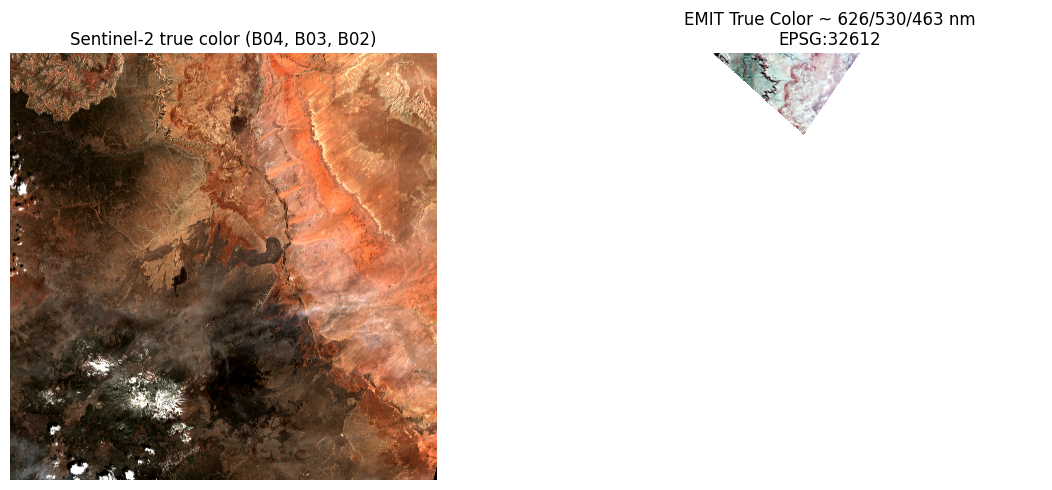

In [81]:
# plot
fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plot_s2_truecolor_from_stack(str(s2_stack), ax=ax1)
path_new = "/content/hyperspectral_super-resolution/" + str(envi_bin)
show_emit_rgb_from_envi(out_dir, pattern=path_new, ax=ax2, gamma=1/2.2)

plt.tight_layout()
plt.show()


In [82]:
# print_raster_geometry("SENTINEL-2", s2_stack)

# print_raster_geometry("EMIT", envi_bin)


In [83]:
out_s2   = S2_DIR   / f"{pair['date']}_s2_overlap.tif"
out_emit = EMIT_DIR / f"{pair['date']}_emit_overlap.bin"

In [84]:
out_s2_overlap   = Path(S2_DIR   / f"{pair['date']}_s2_overlap.tif")
out_emit_overlap = Path(EMIT_DIR / f"{pair['date']}_emit_overlap.bin")

out_s2_overlap, out_emit_overlap = crop_to_overlap(
    s2_path=s2_stack,
    emit_path=envi_bin,
    out_s2_path=str(out_s2_overlap),
    out_emit_path=str(out_emit_overlap),
)

out_emit_overlap = Path(out_emit_overlap)

In [85]:
import rasterio
with rasterio.open(out_s2_overlap) as ds:
    print(ds.driver, ds.count, ds.dtypes[0], ds.descriptions)

GTiff 10 uint16 ('B02_blue', 'B03_green', 'B04_red', 'B08_nir', 'B05_rededge1', 'B06_rededge2', 'B07_rededge3', 'B8A_nir08', 'B11_swir16', 'B12_swir22')


Reading: 2023-04-22_emit_overlap.bin
Picked band 33 at 626.4 nm for target 630.0 nm
Picked band 20 at 529.5 nm for target 532.0 nm
Picked band 11 at 462.6 nm for target 465.0 nm


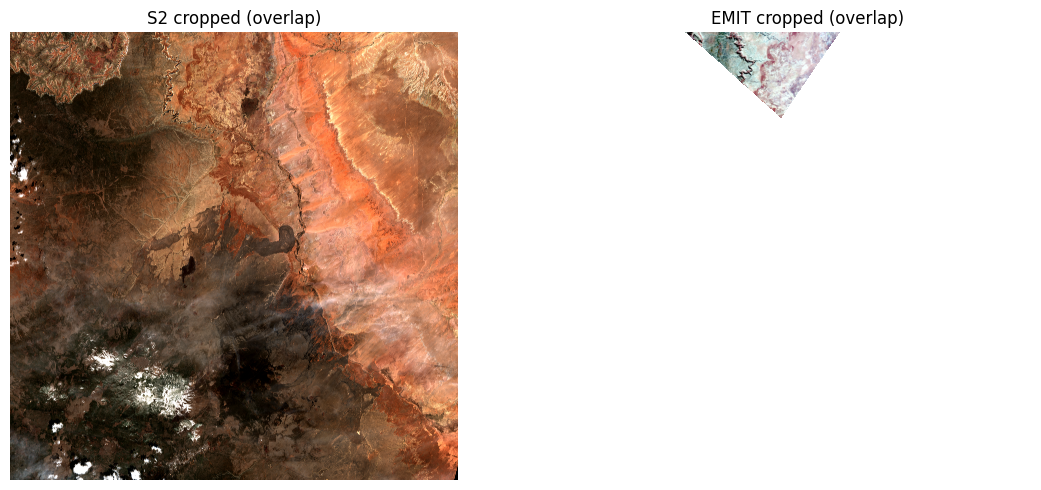

In [86]:
import matplotlib.pyplot as plt
from pathlib import Path

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 🔹 S2 cropped overlap
plot_s2_truecolor_from_stack(str(out_s2_overlap), ax=ax1)
ax1.set_title("S2 cropped (overlap)")
ax1.axis("off")

# 🔹 EMIT cropped overlap
emit_dir  = str(Path(out_emit_overlap).parent)
emit_name = Path(out_emit_overlap).name   # only filename, NOT full path

show_emit_rgb_from_envi(
    out_dir=emit_dir,
    pattern=emit_name,
    ax=ax2,
    gamma=1/2.2,
)
ax2.set_title("EMIT cropped (overlap)")
ax2.axis("off")

plt.tight_layout()
plt.show()


## Tiles

In [87]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path

def plot_tile_pair_simple(emit_tile_path, s2_tile_path, title_suffix="", save_path=None, show=True):
    emit_tile_path = Path(emit_tile_path)
    s2_tile_path   = Path(s2_tile_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    with rasterio.open(s2_tile_path) as ds_s2:
        rgb = ds_s2.read([1, 2, 3]).transpose(1, 2, 0).astype(np.float32)
        vmin = np.percentile(rgb, 2)
        vmax = np.percentile(rgb, 98)
        rgb = np.clip((rgb - vmin) / (vmax - vmin + 1e-6), 0, 1)
        ax1.imshow(rgb)
        ax1.set_title(f"S2 tile {title_suffix}")
        ax1.axis("off")

    with rasterio.open(emit_tile_path) as ds_e:
        best_b, best_var = 1, -1.0
        for b in range(1, ds_e.count + 1):
            arr = ds_e.read(b).astype(np.float32)
            v = float(np.var(arr))
            if v > best_var:
                best_var = v
                best_b = b

        band = ds_e.read(best_b).astype(np.float32)
        vmin = np.percentile(band, 2)
        vmax = np.percentile(band, 98)
        img = (band - vmin) / (vmax - vmin + 1e-6)
        img = np.clip(img, 0, 1) ** 0.5

        print(f"[{title_suffix}] EMIT band {best_b}, var={best_var:.3e}, "
              f"min={band.min()}, max={band.max()}")

        ax2.imshow(img, cmap="gray", vmin=0, vmax=1)
        ax2.set_title(f"EMIT tile {title_suffix}\n(best band {best_b})")
        ax2.axis("off")

    plt.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches="tight")

    if show:
        plt.show()

    plt.close(fig)

In [88]:
from google.colab import drive
from pathlib import Path

drive.mount("/content/drive")

# Change this to wherever you want in Drive
id_str = emit_nc.stem.replace("EMIT_L2A_RFL_", "", 1)

base_out = Path(f"/content/drive/MyDrive/EMIT_S-2_Matches/{id_str}")
tiles_out = base_out / "tiles"
plots_out = base_out / "plots"

tiles_out.mkdir(parents=True, exist_ok=True)
plots_out.mkdir(parents=True, exist_ok=True)

print("Saving tiles to:", tiles_out)
print("Saving plots to:", plots_out)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving tiles to: /content/drive/MyDrive/EMIT_S-2_Matches/001_20230420T200041_2311013_015/tiles
Saving plots to: /content/drive/MyDrive/EMIT_S-2_Matches/001_20230420T200041_2311013_015/plots


In [89]:

def is_black_mask(arr, nodata=None, masked_val=-0.01,
                  nodata_atol=1e-3, zero_atol=1e-6):
    """
    arr: (bands, H, W)

    Pixel is 'black/invalid' if:
      - all bands ≈ nodata          (e.g. -9999)
      - OR all bands ≈ masked_val   (EMIT masked reflectance, ~ -0.01)
      - OR all bands ≈ 0            (true black)
    """
    if nodata is not None:
        nodata_mask = np.all(np.isclose(arr, nodata, atol=nodata_atol), axis=0)
    else:
        nodata_mask = np.zeros(arr.shape[1:], dtype=bool)

    masked_mask = np.all(np.isclose(arr, masked_val, atol=nodata_atol), axis=0)

    zero_mask = np.all(np.abs(arr) < zero_atol, axis=0)

    return nodata_mask | masked_mask | zero_mask


def find_valid_paired_tiles(
    emit_path,
    s2_path,
    emit_tile_size=100,
    scale=6,
    max_black_frac=0.0,
    max_tiles=None
):
    """
    Iterate over EMIT and S2 in paired tiles.
    Assumes:
      - EMIT and S2 cover the same area
      - spatial resolution ratio = `scale` (S2 is finer)
      - S2 height/width ≈ scale * EMIT height/width
    Returns a list of tile descriptors:
      [ { 'emit_window': Window, 's2_window': Window, 'idx': k }, ... ]
    """

    tiles = []

    with rasterio.open(emit_path) as emit_ds, rasterio.open(s2_path) as s2_ds:
        h_e, w_e = emit_ds.height, emit_ds.width
        h_s, w_s = s2_ds.height, s2_ds.width

        ratio_h = h_s / h_e
        ratio_w = w_s / w_e
        print(f"EMIT shape: {h_e}x{w_e}, S2 shape: {h_s}x{w_s}")
        print(f"Pixel ratio (h, w): {ratio_h:.3f}, {ratio_w:.3f}")


        emit_nodata = emit_ds.nodata
        s2_nodata = s2_ds.nodata

        tile_h_e = emit_tile_size
        tile_w_e = emit_tile_size
        tile_h_s = tile_h_e * scale
        tile_w_s = tile_w_e * scale

        idx = 0

        step_y = tile_h_e
        step_x = tile_w_e

        for row_e in range(0, h_e - tile_h_e + 1, step_y):
            for col_e in range(0, w_e - tile_w_e + 1, step_x):


                row_s = row_e * scale
                col_s = col_e * scale

                if (row_s + tile_h_s > h_s) or (col_s + tile_w_s > w_s):
                    continue

                w_emit = Window(col_e, row_e, tile_w_e, tile_h_e)
                w_s2   = Window(col_s, row_s, tile_w_s, tile_h_s)

                emit_tile = emit_ds.read(window=w_emit)
                s2_tile   = s2_ds.read(window=w_s2)

                emit_black = is_black_mask(emit_tile, nodata=emit_nodata)
                s2_black   = is_black_mask(s2_tile, nodata=s2_nodata)

                emit_black_frac = emit_black.sum() / emit_black.size
                s2_black_frac   = s2_black.sum() / s2_black.size

                if (emit_black_frac <= max_black_frac) and (s2_black_frac <= max_black_frac):
                    tiles.append(
                        {
                            "idx": idx,
                            "emit_window": w_emit,
                            "s2_window": w_s2,
                            "emit_black_frac": emit_black_frac,
                            "s2_black_frac": s2_black_frac,
                        }
                    )
                    idx += 1

                    if max_tiles is not None and len(tiles) >= max_tiles:
                        print(f"Collected {len(tiles)} tiles, stopping.")
                        return tiles

        print(f"Total valid tiles found: {len(tiles)}")
        return tiles


In [90]:
from pathlib import Path
import rasterio
from rasterio.windows import transform as window_transform

def _predictor_for(dtype):
    return 3 if dtype.kind == "f" else 2  # 3 for float, 2 for ints

def _block_multiple_of_16(desired, dim):
    # choose a block size <= dim, rounded DOWN to multiple of 16 (min 16)
    b = min(desired, dim)
    b = (b // 16) * 16
    return max(16, b)

def save_tile_pair(
    emit_path,
    s2_path,
    tile_info,
    out_dir,
    tiled=True,           # <-- you control internal tiling here
    emit_block=100,        # desired internal block size (will snap to multiple-of-16)
    s2_block=600,
):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    k = int(tile_info["idx"])

    emit_out = out_dir / f"tile_{k:03d}_emit.tif"
    s2_out   = out_dir / f"tile_{k:03d}_s2.tif"

    # remove existing outputs (prevents the “corrupt tif prevents overwrite” issue)
    emit_out.unlink(missing_ok=True)
    s2_out.unlink(missing_ok=True)

    with rasterio.open(emit_path) as emit_ds, rasterio.open(s2_path) as s2_ds:
        w_emit = tile_info["emit_window"]
        w_s2   = tile_info["s2_window"]

        emit_tile = emit_ds.read(window=w_emit)
        s2_tile   = s2_ds.read(window=w_s2)

        if emit_tile.shape[1] == 0 or emit_tile.shape[2] == 0:
            raise ValueError(f"Empty EMIT tile idx={k}, window={w_emit}")
        if s2_tile.shape[1] == 0 or s2_tile.shape[2] == 0:
            raise ValueError(f"Empty S2 tile idx={k}, window={w_s2}")

        emit_transform = window_transform(w_emit, emit_ds.transform)
        s2_transform   = window_transform(w_s2,   s2_ds.transform)

        # Preserve EMIT tags
        emit_ds_tags   = emit_ds.tags()
        emit_band_tags = [emit_ds.tags(i) for i in range(1, emit_ds.count + 1)]

        # Build fresh GTiff profiles (don’t inherit ENVI block sizes)
        eh, ew = emit_tile.shape[1], emit_tile.shape[2]
        sh, sw = s2_tile.shape[1], s2_tile.shape[2]

        emit_profile = dict(
            driver="GTiff",
            height=eh, width=ew,
            count=emit_tile.shape[0],
            dtype=emit_tile.dtype,
            crs=emit_ds.crs,
            transform=emit_transform,
            nodata=emit_ds.nodata,
            compress="DEFLATE",
            predictor=_predictor_for(emit_tile.dtype),
            BIGTIFF="IF_SAFER",
            tiled=bool(tiled),
            NUM_THREADS= "ALL_CPUS",
            ZLEVEL= 1

        )

        s2_profile = dict(
            driver="GTiff",
            height=sh, width=sw,
            count=s2_tile.shape[0],
            dtype=s2_tile.dtype,
            crs=s2_ds.crs,
            transform=s2_transform,
            nodata=s2_ds.nodata,
            compress="DEFLATE",
            predictor=_predictor_for(s2_tile.dtype),
            BIGTIFF="IF_SAFER",
            tiled=bool(tiled),
            NUM_THREADS= "ALL_CPUS",
            ZLEVEL= 1
        )

        # If internal tiling requested, set valid block sizes (multiples of 16)
        if tiled:
            if ew < 16 or eh < 16 or sw < 16 or sh < 16:
                # Too small for tiled GeoTIFF in this environment
                raise ValueError(
                    f"Tile too small for tiled GeoTIFF (need >=16px). "
                    f"EMIT={ew}x{eh}, S2={sw}x{sh}"
                )

            emit_profile.update(
                blockxsize=_block_multiple_of_16(emit_block, ew),
                blockysize=_block_multiple_of_16(emit_block, eh),
            )
            s2_profile.update(
                blockxsize=_block_multiple_of_16(s2_block, sw),
                blockysize=_block_multiple_of_16(s2_block, sh),
            )

        with rasterio.open(emit_out, "w", **emit_profile) as dst_e:
            dst_e.write(emit_tile)
            if emit_ds_tags:
                dst_e.update_tags(**emit_ds_tags)
            for i, bt in enumerate(emit_band_tags, start=1):
                if bt:
                    dst_e.update_tags(i, **bt)

        with rasterio.open(s2_out, "w", **s2_profile) as dst_s:
            dst_s.write(s2_tile)

    return emit_out, s2_out


In [91]:
valid_tiles = find_valid_paired_tiles(emit_path=str(out_emit_overlap),
                                      s2_path=str(out_s2_overlap),
                                      emit_tile_size=100, scale=6,
                                      max_black_frac=0.0)

EMIT shape: 1830x1830, S2 shape: 10980x10980
Pixel ratio (h, w): 6.000, 6.000
Total valid tiles found: 5


In [92]:
out_emit_overlap

PosixPath('pairs_output/emit/2023-04-22_emit_overlap.bin')

In [93]:
saved_records = []

for tile_info in valid_tiles:
    k = tile_info["idx"]

    # 1) Save the GeoTIFF pair into Drive
    emit_out, s2_out = save_tile_pair(
        emit_path=str(out_emit_overlap),
        s2_path=str(out_s2_overlap),
        tile_info=tile_info,
        out_dir=tiles_out
    )

    # 2) Save the plot PNG into Drive
    plot_png = plots_out / f"tile_{k:03d}_pair.png"
    plot_tile_pair_simple(
        emit_tile_path=emit_out,
        s2_tile_path=s2_out,
        title_suffix=f"{k:03d}",
        save_path=plot_png,
        show=False  # keep notebook clean; set True if you want to display too
    )

    saved_records.append((k, str(emit_out), str(s2_out), str(plot_png)))
    print("Saved:", emit_out.name, s2_out.name, plot_png.name)

print("Done. Total exported:", len(saved_records))

[000] EMIT band 143, var=8.121e-03, min=0.01190660148859024, max=0.608221709728241
Saved: tile_000_emit.tif tile_000_s2.tif tile_000_pair.png
[001] EMIT band 187, var=3.249e-03, min=0.10219985246658325, max=0.5542676448822021
Saved: tile_001_emit.tif tile_001_s2.tif tile_001_pair.png
[002] EMIT band 175, var=2.244e-03, min=0.18424555659294128, max=0.5203478932380676
Saved: tile_002_emit.tif tile_002_s2.tif tile_002_pair.png
[003] EMIT band 174, var=3.975e-03, min=0.15268389880657196, max=0.582688570022583
Saved: tile_003_emit.tif tile_003_s2.tif tile_003_pair.png
[004] EMIT band 175, var=2.939e-03, min=0.17662306129932404, max=0.5095447897911072
Saved: tile_004_emit.tif tile_004_s2.tif tile_004_pair.png
Done. Total exported: 5


In [94]:
df = pd.DataFrame(saved_records, columns=["idx", "emit_tif", "s2_tif", "plot_png"])
csv_path = base_out / "manifest.csv"
df.to_csv(csv_path, index=False)
print("Wrote:", csv_path)

Wrote: /content/drive/MyDrive/EMIT_S-2_Matches/001_20230420T200041_2311013_015/manifest.csv


In [95]:
def describe(path, name):
    with rasterio.open(path) as ds:
        print(f"\n=== {name} ===")
        print("path:", path)
        print("driver:", ds.driver)
        print("count:", ds.count)
        print("dtype:", ds.dtypes[:5], "..." if ds.count > 5 else "")
        print("shape:", ds.height, ds.width)
        print("crs:", ds.crs)
        print("nodata:", ds.nodata)
        print("transform:", ds.transform)

describe(str(out_emit_overlap), "EMIT overlap")
# describe(str(s2_tif),   "S2 overlap")


=== EMIT overlap ===
path: pairs_output/emit/2023-04-22_emit_overlap.bin
driver: GTiff
count: 285
dtype: ('float32', 'float32', 'float32', 'float32', 'float32') ...
shape: 1830 1830
crs: EPSG:32612
nodata: -9999.0
transform: | 60.00, 0.00, 399960.00|
| 0.00,-60.00, 4000020.00|
| 0.00, 0.00, 1.00|


## Color bands

In [96]:
import xarray as xr
import numpy as np

nc_path = emit_nc if "emit_nc" in globals() else max(EMIT_DIR.glob("*.nc"), key=lambda p: p.stat().st_mtime)

ds = xr.open_dataset(nc_path)

print(ds)


<xarray.Dataset> Size: 2GB
Dimensions:      (downtrack: 1280, crosstrack: 1242, bands: 285)
Dimensions without coordinates: downtrack, crosstrack, bands
Data variables:
    reflectance  (downtrack, crosstrack, bands) float32 2GB ...
Attributes: (12/38)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    southernmost_latitude:             35.9491501063592
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-1.12252168e+02  5.42232520e-04 -0.00...
    day_night_flag:  

In [97]:
import h5py, numpy as np

nc_path = emit_nc if "emit_nc" in globals() else max(EMIT_DIR.glob("*.nc"), key=lambda p: p.stat().st_mtime)

with h5py.File(nc_path, "r") as f:
    wavelengths = f["sensor_band_parameters/wavelengths"][:].astype(float)  # nm
    good = f["sensor_band_parameters/good_wavelengths"][:].astype(bool)     # True = usable band

# intervals (all bands)
intervals = np.diff(wavelengths)

print("Total bands:", len(wavelengths))
print("Wavelength range:", wavelengths.min(), "–", wavelengths.max(), "nm")
print("Mean band interval:", intervals.mean(), "nm")
print("Min / Max interval:", intervals.min(), intervals.max())
print("First/last 5:", wavelengths[:5], wavelengths[-5:])

# intervals (good bands only)
w_good = wavelengths[good]
intervals_good = np.diff(w_good)
print("\nGood bands:", len(w_good))
print("Good wavelength range:", w_good.min(), "–", w_good.max(), "nm")
print("Mean interval (good):", intervals_good.mean(), "nm")


Total bands: 285
Wavelength range: 381.0055847167969 – 2492.923828125 nm
Mean band interval: 7.436331842986631 nm
Min / Max interval: 7.38525390625 7.4625244140625
First/last 5: [381.00558472 388.40921021 395.81582642 403.22540283 410.63800049] [2463.3815918  2470.76782227 2478.15307617 2485.53857422 2492.92382812]

Good bands: 244
Good wavelength range: 381.0055847167969 – 2492.923828125 nm
Mean interval (good): 8.691021577811535 nm


In [98]:
import pandas as pd

s2_bands = pd.DataFrame({
    "Band": ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"],
    "Center_nm": [443, 490, 560, 665, 705, 740, 783, 842, 865, 945, 1610, 2190],
    "Bandwidth_nm": [20, 65, 35, 30, 15, 15, 20, 115, 20, 20, 90, 180],
    "Resolution_m": [60,10,10,10,20,20,20,10,20,60,20,20]
})

s2_bands["Start_nm"] = s2_bands["Center_nm"] - s2_bands["Bandwidth_nm"]/2
s2_bands["End_nm"]   = s2_bands["Center_nm"] + s2_bands["Bandwidth_nm"]/2

s2_bands


Band  Center_nm  Bandwidth_nm  Resolution_m  Start_nm  End_nm
0    B1        443            20            60     433.0   453.0
1    B2        490            65            10     457.5   522.5
2    B3        560            35            10     542.5   577.5
3    B4        665            30            10     650.0   680.0
4    B5        705            15            20     697.5   712.5
5    B6        740            15            20     732.5   747.5
6    B7        783            20            20     773.0   793.0
7    B8        842           115            10     784.5   899.5
8   B8A        865            20            20     855.0   875.0
9    B9        945            20            60     935.0   955.0
10  B11       1610            90            20    1565.0  1655.0
11  B12       2190           180            20    2100.0  2280.0

In [99]:
import numpy as np

def pseudo_s2_box_integral(R, emit_w, s2_df, good_mask=None):
    """
    R: (H, W, B) EMIT reflectance (bands last)
    emit_w: (B,) wavelengths (nm)
    s2_df: DataFrame with Band, Start_nm, End_nm
    good_mask: optional (B,) bool
    Returns: dict band->(H,W)
    """
    out = {}
    for _, r in s2_df.iterrows():
        m = (emit_w >= r["Start_nm"]) & (emit_w <= r["End_nm"])
        if good_mask is not None:
            m &= good_mask
        idx = np.where(m)[0]
        if len(idx) < 2:
            out[r["Band"]] = None
            continue

        w = emit_w[idx]
        y = R[..., idx]  # (H,W,K)

        # trapezoid integral over wavelength, then normalize by band width
        num = np.trapz(y, x=w, axis=-1)
        den = (w[-1] - w[0])
        out[r["Band"]] = num / den
    return out


# Color matching

### Helpers

In [144]:
import re
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge

In [145]:
def read_raster(path, bands=None):
    """Read raster bands as float32 array (B,H,W) + profile + nodata."""
    with rasterio.open(path) as ds:
        arr = ds.read() if bands is None else ds.read(bands)
        arr = arr.astype(np.float32)
        profile = ds.profile.copy()
        nodata = ds.nodata
    return arr, profile, nodata

In [146]:
def resample_cube_to_profile(cube_bhw, src_profile, dst_profile, resampling=Resampling.bilinear):
    """
    Returns (B, dst_H, dst_W)
    """
    B = cube_bhw.shape[0]
    dst_h, dst_w = dst_profile["height"], dst_profile["width"]
    dst = np.empty((B, dst_h, dst_w), dtype=np.float32)

    for b in range(B):
        reproject(
            source=cube_bhw[b],
            destination=dst[b],
            src_transform=src_profile["transform"],
            src_crs=src_profile["crs"],
            dst_transform=dst_profile["transform"],
            dst_crs=dst_profile["crs"],
            resampling=resampling,
            src_nodata=src_profile.get("nodata", None),
            dst_nodata=dst_profile.get("nodata", None),
        )
    return dst

In [147]:
def subsample_bands_evenly(num_bands_total, num_keep=32):
    """Pick evenly spaced band indices (needed for EMIT) [0..num_bands_total-1]."""
    idx = np.linspace(0, num_bands_total - 1, num_keep).round().astype(int)
    idx = np.unique(idx)

    while len(idx) < num_keep:
        missing = num_keep - len(idx)
        add = []
        for i in range(len(idx) - 1):
            if len(add) >= missing:
                break
            mid = (idx[i] + idx[i + 1]) // 2
            add.append(int(mid))
        idx = np.unique(np.concatenate([idx, np.array(add, dtype=int)]))
    return idx[:num_keep]

In [148]:
def flatten_pixels(X_bhw, Y_bhw, x_nodata=None, y_nodata=None):
    """
    X_bhw: (Bx,H,W), Y_bhw: (By,H,W)
    returns X:(N,Bx), Y:(N,By) with finite pixels only (+ nodata filtered)
    """
    Bx, H, W = X_bhw.shape
    By, Hy, Wy = Y_bhw.shape
    assert (H, W) == (Hy, Wy)

    X = X_bhw.reshape(Bx, -1).T
    Y = Y_bhw.reshape(By, -1).T

    mask = np.isfinite(X).all(axis=1) & np.isfinite(Y).all(axis=1)
    if x_nodata is not None:
        mask &= ~(np.isclose(X, x_nodata).any(axis=1))
    if y_nodata is not None:
        mask &= ~(np.isclose(Y, y_nodata).any(axis=1))

    return X[mask], Y[mask]

In [149]:
def read_emit_wavelengths_from_band_tags(path):
    """
    Reads wavelengths from GeoTIFF tags."""
    with rasterio.open(path) as ds:
        tags = ds.tags()
        count = ds.count

    band_map = {}
    for k, v in tags.items():
        m = re.fullmatch(r"Band_(\d+)", k)
        if not m:
            continue
        band_idx_1based = int(m.group(1))
        nums = re.findall(r"[-+]?\d*\.\d+|\d+", str(v))
        if not nums:
            continue
        band_map[band_idx_1based] = float(nums[0])

    max_band = max(band_map.keys())
    B = count if count is not None else max_band
    wl = np.full(B, np.nan, dtype=np.float32)

    for b1, w in band_map.items():
        if 1 <= b1 <= B:
            wl[b1 - 1] = w

    return wl

In [150]:
def logit(x, eps=1e-4):
    x = np.clip(x, eps, 1.0 - eps)
    return np.log(x / (1.0 - x))

def sigmoid(z):

    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

In [151]:
def predict_cube_logit(model, X_bhw, nodata=None, batch_pixels=200_000):
    """
    model predicts logit-space EMIT (N,32).
    Returns EMIT prediction in [0,1] as (32,H,W).
    """
    B, H, W = X_bhw.shape
    X = X_bhw.reshape(B, -1).T

    valid = np.isfinite(X).all(axis=1)
    if nodata is not None:
        valid &= ~(np.isclose(X, nodata).any(axis=1))

    Y_pred = np.full((X.shape[0], 32), np.nan, dtype=np.float32)
    idx = np.where(valid)[0]

    for start in range(0, len(idx), batch_pixels):
        sl = idx[start:start + batch_pixels]
        y_logit = model.predict(X[sl]).astype(np.float32)
        y = sigmoid(y_logit).astype(np.float32)
        Y_pred[sl] = y

    return Y_pred.T.reshape(32, H, W)

In [152]:
def rgb_from_cube(cube_bhw, r, g, b):
    return np.stack([cube_bhw[r], cube_bhw[g], cube_bhw[b]], axis=-1).astype(np.float32)

def compute_shared_stretch_params(imgs_hwc, p_low=2, p_high=98):
    lo = np.zeros(3, dtype=np.float32)
    hi = np.ones(3, dtype=np.float32)
    for c in range(3):
        vals = np.concatenate([im[..., c].ravel() for im in imgs_hwc])
        vals = vals[np.isfinite(vals)]
        lo[c] = np.percentile(vals, p_low)
        hi[c] = np.percentile(vals, p_high)
    return lo, hi

def apply_stretch(img_hwc, lo, hi, gamma=1.1, eps=1e-6):
    out = (img_hwc - lo) / (hi - lo + eps)
    out = np.clip(out, 0, 1).astype(np.float32)
    if gamma and gamma != 1.0:
        out = out ** (1.0 / gamma)
    return out

In [153]:
emit_full, emit_prof, emit_nodata = read_raster(emit_path)
s2_10m, s2_prof_10m, s2_nodata = read_raster(s2_path_10m)

In [154]:
print("EMIT:", emit_full.shape, "pixel:", emit_prof["transform"].a)
print("S2  :", s2_10m.shape, "pixel:", s2_prof_10m["transform"].a)

EMIT: (285, 100, 100) pixel: 60.0
S2  : (10, 600, 600) pixel: 10.0


In [155]:
s2_min, s2_max = float(np.nanmin(s2_10m)), float(np.nanmax(s2_10m))
emit_min, emit_max = float(np.nanmin(emit_full)), float(np.nanmax(emit_full))
print("Ranges: S2 min/max =", s2_min, s2_max, "| EMIT min/max =", emit_min, emit_max)

Ranges: S2 min/max = 1.0 16120.0 | EMIT min/max = -0.02514391764998436 0.608221709728241


Sample 32 bands from EMIT:

In [156]:
emit_idx32 = subsample_bands_evenly(emit_full.shape[0], num_keep=32)
emit_32 = emit_full[emit_idx32]

In [157]:
emit_wavelengths_full = read_emit_wavelengths_from_band_tags(emit_path)
wavelengths_32 = emit_wavelengths_full[emit_idx32]

In [158]:
print("EMIT_32:", emit_32.shape)
print("wavelengths_32 (nm) first 10:", wavelengths_32[:10])

EMIT_32: (32, 100, 100)
wavelengths_32 (nm) first 10: [381.00558 447.7428  514.6504  581.6585  656.1857  723.2993  790.4379
 857.5937  924.7538  991.9114 ]


In [159]:
s2_60m = resample_cube_to_profile(s2_10m, s2_prof_10m, emit_prof, resampling=Resampling.bilinear)
print("S2 -> EMIT grid:", s2_60m.shape)

S2 -> EMIT grid: (10, 100, 100)


Training:

In [161]:
X_train, Y_train = flatten_pixels(s2_60m, emit_32, x_nodata=s2_nodata, y_nodata=emit_nodata)
print("Train pixels:", X_train.shape, "Targets:", Y_train.shape)

Train pixels: (10000, 10) Targets: (10000, 32)


In [162]:
Y_train_logit = logit(Y_train, eps=1e-4)

Model params:

In [163]:
deg = 2
alpha = 1.0

Scaling -> polynomial features -> linear regression with L2 regularization:

In [164]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
    ("ridge", Ridge(alpha=alpha)),
])

In [165]:
model.fit(X_train, Y_train_logit)
print("Fitted model: degree =", deg, "alpha =", alpha)

Fitted model: degree = 2 alpha = 1.0


In [166]:

Yhat_logit = model.predict(X_train).astype(np.float32)
Yhat = sigmoid(Yhat_logit)

r2_per_band = []
rmse_per_band = []
for j in range(32):
    yt = Y_train[:, j]
    yp = Yhat[:, j]
    m = np.isfinite(yt) & np.isfinite(yp)
    yt = yt[m]; yp = yp[m]
    ss_res = np.sum((yt - yp) ** 2)
    ss_tot = np.sum((yt - yt.mean()) ** 2) + 1e-8
    r2 = 1.0 - ss_res / ss_tot
    rmse = np.sqrt(np.mean((yt - yp) ** 2))
    r2_per_band.append(float(r2))
    rmse_per_band.append(float(rmse))

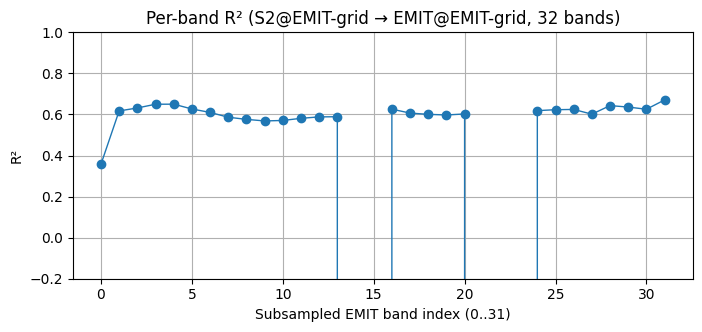

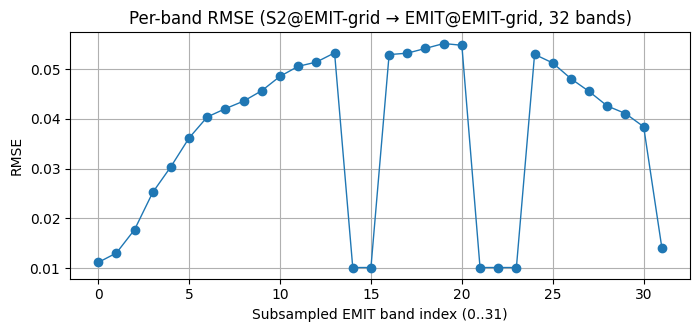

Pred EMIT @10m: (32, 600, 600)


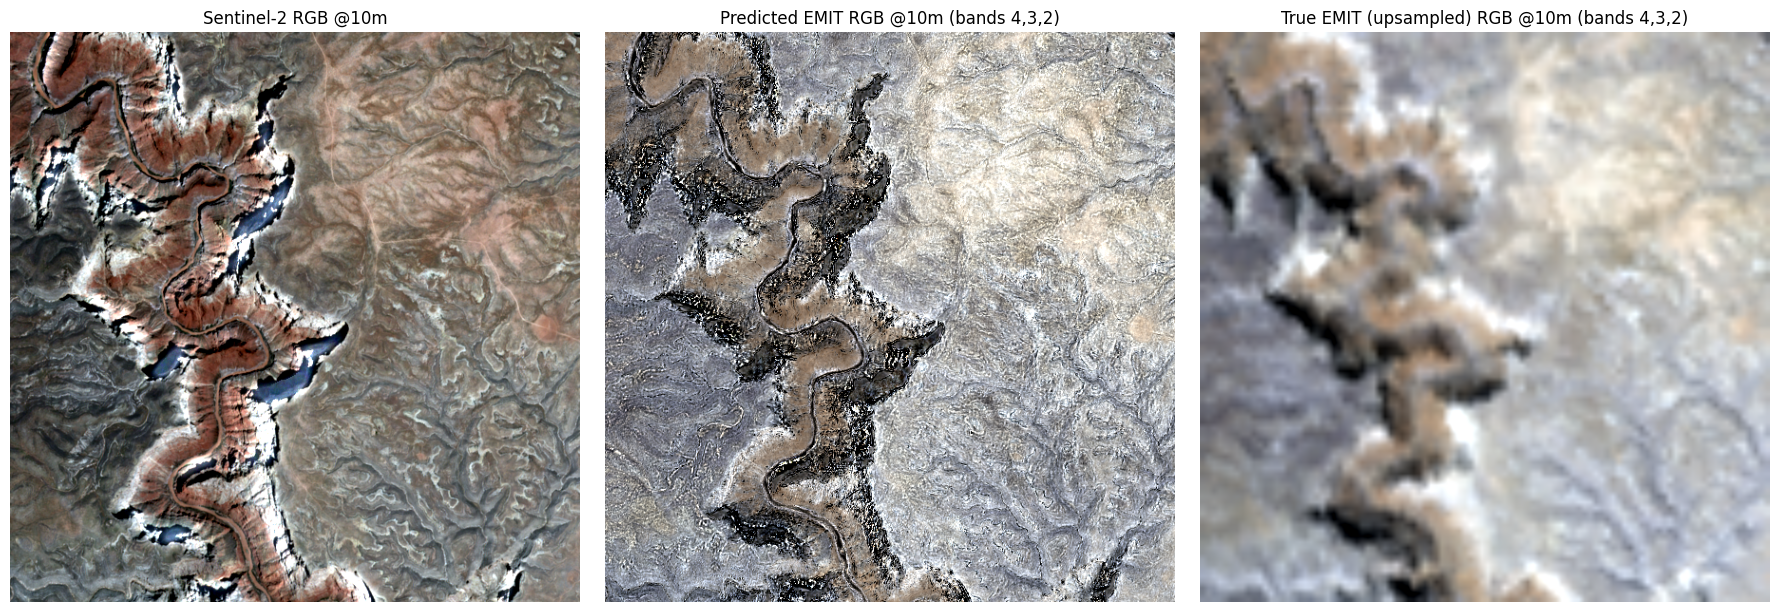

In [168]:
r2_per_band = np.array(r2_per_band)
rmse_per_band = np.array(rmse_per_band)

plt.figure(figsize=(8,3.2))
plt.plot(r2_per_band, marker="o", linewidth=1)
plt.title("Per-band R² (S2@EMIT-grid → EMIT@EMIT-grid, 32 bands)")
plt.xlabel("Subsampled EMIT band index (0..31)")
plt.ylabel("R²")
plt.grid(True)
plt.ylim(-0.2, 1.0)
plt.show()

plt.figure(figsize=(8,3.2))
plt.plot(rmse_per_band, marker="o", linewidth=1)
plt.title("Per-band RMSE (S2@EMIT-grid → EMIT@EMIT-grid, 32 bands)")
plt.xlabel("Subsampled EMIT band index (0..31)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

emit_pred_10m = predict_cube_logit(model, s2_10m, nodata=s2_nodata)
print("Pred EMIT @10m:", emit_pred_10m.shape)

RGB_WAVELENGTHS = {"B": 490, "G": 560, "R": 665}
emitB = int(np.nanargmin(np.abs(wavelengths_32 - RGB_WAVELENGTHS["B"])))
emitG = int(np.nanargmin(np.abs(wavelengths_32 - RGB_WAVELENGTHS["G"])))
emitR = int(np.nanargmin(np.abs(wavelengths_32 - RGB_WAVELENGTHS["R"])))

# print("EMIT RGB indices (32-band cube):", (emitR, emitG, emitB))
# print("EMIT RGB wavelengths (nm):", wavelengths_32[[emitR, emitG, emitB]])


s2_rgb_10m = rgb_from_cube(s2_10m, r=2, g=1, b=0)

emit_true_10m = resample_cube_to_profile(emit_32, emit_prof, s2_prof_10m, resampling=Resampling.bilinear)

emit_pred_rgb_10m = rgb_from_cube(emit_pred_10m, r=emitR, g=emitG, b=emitB)
emit_true_rgb_10m = rgb_from_cube(emit_true_10m, r=emitR, g=emitG, b=emitB)

lo, hi = compute_shared_stretch_params([emit_pred_rgb_10m, emit_true_rgb_10m], p_low=2, p_high=98)
emit_pred_vis = apply_stretch(emit_pred_rgb_10m, lo, hi, gamma=1.1)
emit_true_vis = apply_stretch(emit_true_rgb_10m, lo, hi, gamma=1.1)

s2_lo, s2_hi = compute_shared_stretch_params([s2_rgb_10m], p_low=2, p_high=98)
s2_vis = apply_stretch(s2_rgb_10m, s2_lo, s2_hi, gamma=1.1)

plt.figure(figsize=(18,6))
for i, (img, title) in enumerate([
    (s2_vis, "Sentinel-2 RGB @10m"),
    (emit_pred_vis, f"Predicted EMIT RGB @10m (bands {emitR},{emitG},{emitB})"),
    (emit_true_vis, f"True EMIT (upsampled) RGB @10m (bands {emitR},{emitG},{emitB})"),
], 1):
    ax = plt.subplot(1,3,i)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()
